In [1]:
"""
Changes from AblationOHE:
-correlation of features
"""

'\nChanges from AblationOHE:\n-correlation of features\n'

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
from Data_cleaning import *
from helpers import *
from exploratory_data_analysis import *
from preprocessing import *

In [3]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("data\dataset\dataset")

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\cgreg\AppData\Local\Temp\ipykernel_17336\4219252773.py:1: SyntaxWarning: invalid escape sequence '\d'
  x_train, x_test, y_train, train_ids, test_ids = load_csv_data("data\dataset\dataset")


In [41]:
Y_tr = (y_train + 1) / 2

In [42]:
X_train, keep_mask = remove_nan_features(x_train, 0.2)
X_test = x_test[:, keep_mask]

In [43]:
print(X_train.shape, X_test.shape)

(328135, 143) (109379, 143)


In [44]:
cat_mask, num_mask = detect_categorical_features(X_train, max_unique=10)

In [45]:
print(np.sum(cat_mask), np.sum(num_mask))

99 44


In [46]:
x_tr, y_tr, x_va, y_va, x_te, y_te = stratified_three_way_split(X_train, Y_tr)

In [47]:
print(X_train.shape, x_tr.shape, y_tr.shape, x_va.shape, y_va.shape, x_te.shape, y_te.shape)

(328135, 143) (229695, 143) (229695,) (49220, 143) (49220,) (49220, 143) (49220,)


In [48]:
# Numerical imputation (compute medians from training)
x_tr_imp, medians = impute_numerical(x_tr, num_mask)
# Apply same medians to val/test
x_va_imp, _ = impute_numerical(x_va, num_mask, medians)
x_te_imp, _ = impute_numerical(x_te, num_mask, medians)
x_test_imp, _ = impute_numerical(X_test, num_mask, medians)
# Categorical imputation (compute modes from training)
x_tr_imp, modes = impute_categorical(x_tr_imp, cat_mask)
# Apply same modes to val/test
x_va_imp, _ = impute_categorical(x_va_imp, cat_mask, modes)
x_te_imp, _ = impute_categorical(x_te_imp, cat_mask, modes)
x_test_imp, _ = impute_categorical(x_test_imp, cat_mask, modes)

In [49]:
# Check for any remaining NaN values
print(np.isnan(x_tr_imp).sum(),
      np.isnan(x_va_imp).sum(),
      np.isnan(x_te_imp).sum(), np.isnan(x_test_imp).sum())

0 0 0 0


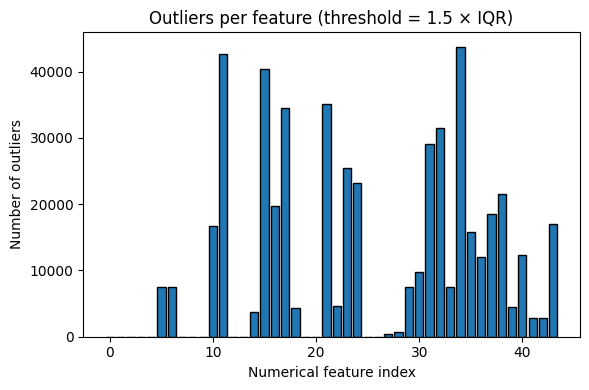

In [50]:
outlier_mask, outlier_counts = detect_outliers(x_tr_imp, num_mask, threshold=1.5, plot=True)

In [51]:
print(outlier_counts)

[    0     0     0     0     0  7523  7523     0     0     0 16765 42722
     0     0  3745 40468 19668 34545  4275     0     0 35062  4608 25522
 23171     0     0   441   754  7544  9823 29058 31441  7525 43748 15806
 12023 18456 21474  4498 12403  2772  2772 16957]


In [52]:
outlier_pctg = outlier_counts / x_tr_imp.shape[0]
print(outlier_pctg)

[0.         0.         0.         0.         0.         0.03275213
 0.03275213 0.         0.         0.         0.07298809 0.18599447
 0.         0.         0.01630423 0.17618146 0.08562659 0.15039509
 0.01861164 0.         0.         0.1526459  0.02006139 0.11111256
 0.10087725 0.         0.         0.00191994 0.00328261 0.03284355
 0.04276541 0.12650689 0.13688152 0.03276084 0.19046126 0.06881299
 0.05234332 0.08035003 0.09348919 0.01958249 0.05399769 0.01206818
 0.01206818 0.07382398]


In [53]:
drop_threshold = 1
new_num_mask = outlier_pctg < drop_threshold


In [54]:
#Change the mask again
keep_mask = np.ones(x_tr_imp.shape[1], dtype=bool)
num_indices = np.where(num_mask)[0]
keep_mask[num_indices] = new_num_mask

In [55]:
x_tr_filt = x_tr_imp[:, keep_mask]
x_va_filt = x_va_imp[:, keep_mask]
x_te_filt = x_te_imp[:, keep_mask]
x_test_filt = x_test_imp[:, keep_mask]
num_mask = num_mask[keep_mask]
cat_mask = cat_mask[keep_mask]

In [56]:
print(np.sum(num_mask), np.sum(cat_mask))

44 99


In [57]:
# Fit one-hot encoder on training data
x_tr_enc, categories = one_hot_encode(x_tr_filt, cat_mask, drop_first=True)

# Apply the same categories to validation and test data
x_va_enc, _ = one_hot_encode(x_va_filt, cat_mask, categories, drop_first=True)
x_te_enc, _ = one_hot_encode(x_te_filt, cat_mask, categories, drop_first=True)
x_test_enc, _ = one_hot_encode(x_test_filt, cat_mask, categories, drop_first=True)

In [58]:
print(x_tr_enc.shape, x_va_enc.shape, x_te_enc.shape, x_test_enc.shape) 

(229695, 368) (49220, 368) (49220, 368) (109379, 368)


In [59]:
cat_mask_enc, num_mask_enc = detect_categorical_features(x_tr_enc, max_unique=10)

In [60]:
print(np.sum(cat_mask_enc), np.sum(num_mask_enc))

324 44


In [61]:
print(np.max(x_tr_enc[:,cat_mask_enc]))

1.0


In [62]:
x_tr_std, means, stds = standardize_features(x_tr_enc, num_mask_enc)
x_va_std, _, _ = standardize_features(x_va_enc, num_mask_enc, means, stds)
x_te_std, _, _ = standardize_features(x_te_enc, num_mask_enc, means, stds)
x_test_std, _, _ = standardize_features(x_test_enc, num_mask_enc, means, stds)

In [27]:
corr_y = feature_target_correlation(x_tr_std, y_tr)


In [63]:

min_corr = 0
keep_mask_corr = np.abs(corr_y) > min_corr


In [64]:
x_tr_sel = x_tr_std[:, keep_mask_corr]
x_va_sel = x_va_std[:, keep_mask_corr]
x_te_sel = x_te_std[:, keep_mask_corr]
x_test_sel = x_test_std[:, keep_mask_corr]

In [65]:
print(x_tr_sel.shape, x_va_sel.shape, x_te_sel.shape, x_test_sel.shape)

(229695, 368) (49220, 368) (49220, 368) (109379, 368)


In [66]:
cat_mask_sel, num_mask_sel = detect_categorical_features(x_tr_sel, max_unique=10)

In [67]:
print(np.sum(cat_mask_sel))

324


In [68]:
corr_mat = correlation_matrix(x_tr_sel)


In [69]:
threshold = 0.9
to_drop = set()

for i in range(corr_mat.shape[0]):
    for j in range(i + 1, corr_mat.shape[1]):
        if abs(corr_mat[i, j]) > threshold:
            # Compare absolute correlation with y
            if abs(corr_y[i]) < abs(corr_y[j]):
                to_drop.add(i)
            else:
                to_drop.add(j)

keep_mask_inter = np.ones(x_tr_sel.shape[1], dtype=bool)
keep_mask_inter[list(to_drop)] = False



In [70]:
x_tr_final = x_tr_sel[:, keep_mask_inter]
x_va_final = x_va_sel[:, keep_mask_inter]
x_te_final = x_te_sel[:, keep_mask_inter]
x_test_final = x_test_sel[:, keep_mask_inter]

In [71]:
print("Dropped (low corr):", np.sum(~keep_mask_corr))
print("Dropped (high inter):", np.sum(~keep_mask_inter))
print("Remaining features:", x_tr_final.shape[1])


Dropped (low corr): 0
Dropped (high inter): 82
Remaining features: 286


In [164]:
best_params, best_f1, results = grid_search(
    y_tr, x_tr_final,
    y_va, x_va_final,
    pos_weights=[5.1],
    lambdas=[1e-8],
    thresholds=np.linspace(0.5, 0.85, 200),
    max_iter=10000,
    gamma=0.5
)


#Best F1 = 0.4208 at pos_weight=9.35, λ=1e-08, threshold=0.7324120603015075; 3,35,2
#Best F1 = 0.4208 at pos_weight=9.22, λ=1e-08, threshold=0.7304020100502513; 25 22 27 35
#Best F1 = 0.4201 at pos_weight=10, λ=1e-08, threshold=0.7183417085427136; 10.0
# 6, 0.65, 
"""Confusion Matrix: 10.0, 4.266
[[40489  4385]
 [ 1979  2367]]
TN=40489, FP=4385, FN=1979, TP=2367"""
"""Confusion Matrix: 5, 0.55, 0.4276
[[41486  3388]
 [ 2283  2063]]
TN=41486, FP=3388, FN=2283, TP=2063"""
"""Confusion Matrix: 3, 0.55, 0.4024
[[42578  2296]
 [ 2673  1673]]
TN=42578, FP=2296, FN=2673, TP=1673"""
"""Confusion Matrix: 4, 0.5281407035175879, 0.4218
[[41023  3851]
 [ 2137  2209]]
TN=41023, FP=3851, FN=2137, TP=2209"""
#0.5633165829145729 for 4.5 in 7,9.22,5.5,4.5
#0.5949748743718593 for 5.1 in 5.1 5 4.9 5.25 4.75



=== Run 1/1 (pos_weight=5.1, lambda_=1e-08) ===
New best F1 = 0.4139
New best F1 = 0.4142
New best F1 = 0.4144
New best F1 = 0.4152
New best F1 = 0.4160
New best F1 = 0.4162
New best F1 = 0.4165
New best F1 = 0.4169
New best F1 = 0.4171
New best F1 = 0.4173
New best F1 = 0.4178
New best F1 = 0.4178
New best F1 = 0.4181
New best F1 = 0.4184
New best F1 = 0.4186
New best F1 = 0.4193
New best F1 = 0.4198
New best F1 = 0.4204
New best F1 = 0.4213
New best F1 = 0.4215
New best F1 = 0.4218

=== Grid Search Complete ===
Best F1 = 0.4218 at pos_weight=5.1, λ=1e-08, threshold=0.6037688442211055


'Confusion Matrix: 4, 0.5281407035175879, 0.4218\n[[41023  3851]\n [ 2137  2209]]\nTN=41023, FP=3851, FN=2137, TP=2209'

In [165]:
x_train.shape

(328135, 321)

In [166]:
X_final = np.vstack([x_tr_final, x_va_final])
y_final = np.concatenate([y_tr, y_va])


In [180]:
best_lambda = 1e-8
best_pos_weight = 5
best_neg_weight = 1.0
best_threshold = 0.6037688442211055
final_loss, w_final = logistic_regression_weighted_gd(
    y_final, X_final,
    lambda_=best_lambda,
    gamma=0.5,
    pos_weight=best_pos_weight,
    neg_weight=best_neg_weight,
    max_iter=1000,
    verbose=True
)

print("Final training loss:", final_loss)


Iter     0 | Loss = 0.693147 | GradNorm = 0.9892
Iter   100 | Loss = 0.438641 | GradNorm = 0.0118
Iter   200 | Loss = 0.434736 | GradNorm = 0.0067
Iter   300 | Loss = 0.433187 | GradNorm = 0.0046
Iter   400 | Loss = 0.432376 | GradNorm = 0.0035
Iter   500 | Loss = 0.431885 | GradNorm = 0.0028
Iter   600 | Loss = 0.431558 | GradNorm = 0.0023
Iter   700 | Loss = 0.431326 | GradNorm = 0.0020
Iter   800 | Loss = 0.431152 | GradNorm = 0.0017
Iter   900 | Loss = 0.431017 | GradNorm = 0.0015
Final training loss: 0.4309102503918561


In [181]:
print(w_final @ w_final)

6.942650982009888


In [ ]:
acc, f1 = evaluate_model(y_te, x_te_final, w_final, best_threshold)

 Accuracy: 86.89%
 F1 Score: 0.4276


Confusion Matrix:
[[40355  4519]
 [ 1935  2411]]
TN=40355, FP=4519, FN=1935, TP=2411


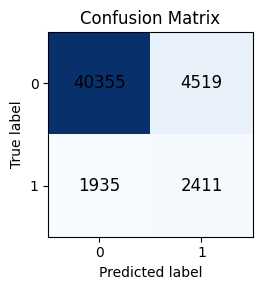

In [178]:
preds, _ = predict_with_threshold(x_te_final, w_final, threshold=best_threshold)
cm = confusion_matrix_numpy(y_te, preds)

In [179]:
y_pred_final, _ = predict_with_threshold(x_test_final, w_final, best_threshold)
y_pred_final = 2 * y_pred_final - 1   # converts 0→-1, 1→1

create_csv_submission(test_ids, y_pred_final, "Ablation_preds.csv")